# Gensim Word2Vec Tutorial

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## 데이터 불러오기

In [2]:
df = pd.read_csv('data/simpsons/simpsons_dataset.csv')
print(df.shape)
df.head()

(158314, 2)


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


## 결측치 처리

In [3]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [4]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## 불용어 제거

In [5]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [7]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.79 mins


In [8]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85954, 1)

## Bigrams

In [9]:
from gensim.models.phrases import Phrases, Phraser

In [10]:
sent = [row.split() for row in df_clean['clean']]

In [11]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 15:07:12: collecting all words and their counts
INFO - 15:07:12: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:07:12: PROGRESS: at sentence #10000, processed 63557 words and 52796 word types
INFO - 15:07:12: PROGRESS: at sentence #20000, processed 130938 words and 99801 word types
INFO - 15:07:12: PROGRESS: at sentence #30000, processed 192959 words and 138413 word types
INFO - 15:07:12: PROGRESS: at sentence #40000, processed 249832 words and 172509 word types
INFO - 15:07:12: PROGRESS: at sentence #50000, processed 311271 words and 208406 word types
INFO - 15:07:13: PROGRESS: at sentence #60000, processed 373576 words and 243519 word types
INFO - 15:07:13: PROGRESS: at sentence #70000, processed 436427 words and 278547 word types
INFO - 15:07:13: PROGRESS: at sentence #80000, processed 497891 words and 311704 word types
INFO - 15:07:13: collected 330480 word types from a corpus of 537095 words (unigram + bigrams) and 85954 sentences
INFO - 15:07:13: us

In [12]:
bigram = Phraser(phrases)

INFO - 15:07:13: source_vocab length 330480
INFO - 15:07:15: Phraser built with 127 phrasegrams


In [13]:
sentences = bigram[sent]

In [14]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30242

In [15]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

## Training the model

In [16]:
import multiprocessing

from gensim.models import Word2Vec

In [17]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

16

In [18]:
w2v_model = Word2Vec(min_count=20, # 단어로 사용하기 단어가 나오는 위해 최소 빈도수
                     window=2,     # word2vec의 window 값
                     size=300,     # 단어의 차원수 ex (10, 100) 1100개의 feature를가진 0개의 단어
                     sample=6e-5,  # 
                     alpha=0.03,   # 초기 학습률
                     min_alpha=0.0007,  # 초기학습률부터 최소학습률까지 선형적으로 감소
                     negative=20,  # negative sampling 할 때 추출한 0label의 단어 개수
                     workers=cores-1) # 멀티 프로세싱하기위한 cpu core 수

In [19]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:07:16: collecting all words and their counts
INFO - 15:07:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:07:16: PROGRESS: at sentence #10000, processed 61710 words, keeping 9572 word types
INFO - 15:07:17: PROGRESS: at sentence #20000, processed 127345 words, keeping 14535 word types
INFO - 15:07:17: PROGRESS: at sentence #30000, processed 187806 words, keeping 17660 word types
INFO - 15:07:17: PROGRESS: at sentence #40000, processed 243314 words, keeping 20424 word types
INFO - 15:07:17: PROGRESS: at sentence #50000, processed 303176 words, keeping 22934 word types
INFO - 15:07:17: PROGRESS: at sentence #60000, processed 363916 words, keeping 25246 word types
INFO - 15:07:17: PROGRESS: at sentence #70000, processed 425379 words, keeping 27467 word types
INFO - 15:07:17: PROGRESS: at sentence #80000, processed 485507 words, keeping 29350 word types
INFO - 15:07:17: collected 30242 word types from a corpus of 523616 raw words and 85954 sentence

Time to build vocab: 0.03 mins


In [20]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:07:18: training model with 15 workers on 3309 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:07:19: EPOCH 1 - PROGRESS: at 20.14% examples, 35037 words/s, in_qsize 23, out_qsize 0
INFO - 15:07:19: worker thread finished; awaiting finish of 14 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 13 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 12 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 11 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 10 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 9 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 8 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 7 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 6 more threads
INFO - 15:07:19: worker thread finished; awaiting finish of 5 more threads
INFO - 15:07:

Time to train the model: 0.67 mins


In [21]:
w2v_model.init_sims(replace=True)

INFO - 15:07:58: precomputing L2-norms of word weight vectors


## Exploring the model

In [22]:
w2v_model.wv.most_similar(positive=["homer"])

[('gee', 0.7733991146087646),
 ('sweetheart', 0.7711714506149292),
 ('marge', 0.7584361433982849),
 ('snuggle', 0.7435159683227539),
 ('rude', 0.7412682175636292),
 ('fault', 0.7373032569885254),
 ('carefully', 0.7333784699440002),
 ('ask', 0.7307949066162109),
 ('creepy', 0.7307645082473755),
 ('happen', 0.7302831411361694)]

In [23]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulation', 0.8011293411254883),
 ('council', 0.7793276906013489),
 ('select', 0.7510597705841064),
 ('recent', 0.7402850389480591),
 ('fellow', 0.7390292882919312),
 ('request', 0.7316831350326538),
 ('united_states', 0.7310537695884705),
 ('springfielder', 0.727884829044342),
 ('montgomery_burns', 0.7273439764976501),
 ('threat', 0.7253726720809937)]

In [24]:
w2v_model.wv.most_similar(positive=["marge"])

[('hammock', 0.7847882509231567),
 ('grownup', 0.7714762091636658),
 ('becky', 0.7648746371269226),
 ('humiliate', 0.7590140104293823),
 ('sweetheart', 0.7587919235229492),
 ('homer', 0.7584362030029297),
 ('rude', 0.7558637857437134),
 ('creepy', 0.7557446956634521),
 ('terrific', 0.7467159032821655),
 ('fault', 0.7440350651741028)]

In [25]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8782081007957458),
 ('mom', 0.7994480133056641),
 ('milhouse', 0.7867234945297241),
 ('ralphie', 0.7761790752410889),
 ('substitute', 0.7729514837265015),
 ('surprised', 0.7679237127304077),
 ('mom_dad', 0.7677178978919983),
 ('pay_attention', 0.7666963338851929),
 ('strangle', 0.7641452550888062),
 ('selfish', 0.7547661662101746)]

In [26]:
w2v_model.wv.similarity("moe", 'tavern')

0.8748673

In [27]:
w2v_model.wv.similarity('maggie', 'baby')

0.67886305

In [28]:
w2v_model.wv.similarity('bart', 'nelson')

0.5961273

## Odd-One-Out

In [29]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 15:07:59: vectors for words {'kearney'} are not present in the model, ignoring these words
C:\Users\saeji\anaconda3\envs\tensorflow2.3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'jimbo'

In [30]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [31]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

## Analogy difference

In [32]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('marry', 0.6566294431686401),
 ('adopt', 0.6175602078437805),
 ('married', 0.5929787158966064)]

In [33]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.752126157283783),
 ('work_hard', 0.7173753380775452),
 ('parent', 0.717026948928833)]

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [35]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

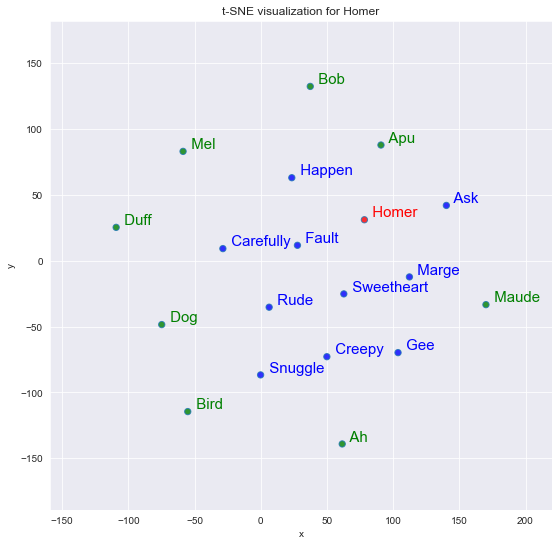

In [36]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

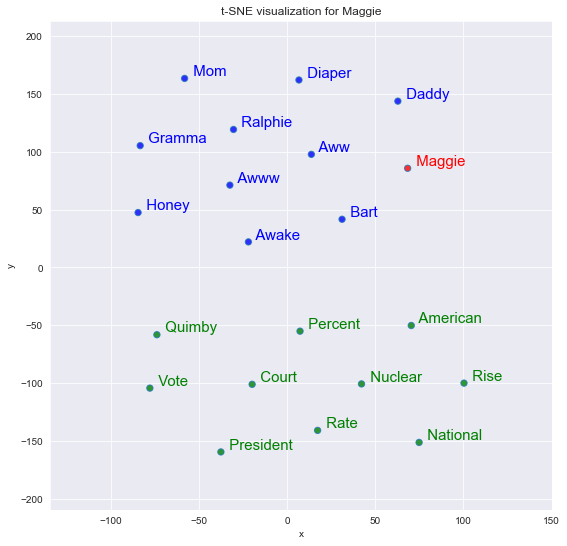

In [37]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

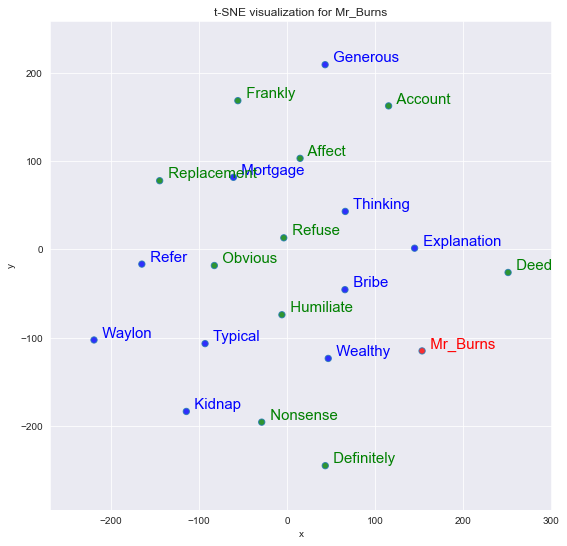

In [41]:
tsnescatterplot(w2v_model, "mr_burns", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burns"], topn=20)][10:])